# 色温度変換をしてみる

## 参考サイト
[Bradford 変換 (白色点の変換)](http://w3.kcua.ac.jp/~fujiwara/infosci/colorspace/bradford.html)

[色温度のxy色度(英語版Wikipediaより)](https://en.wikipedia.org/wiki/Standard_illuminant#White_points_of_standard_illuminants)

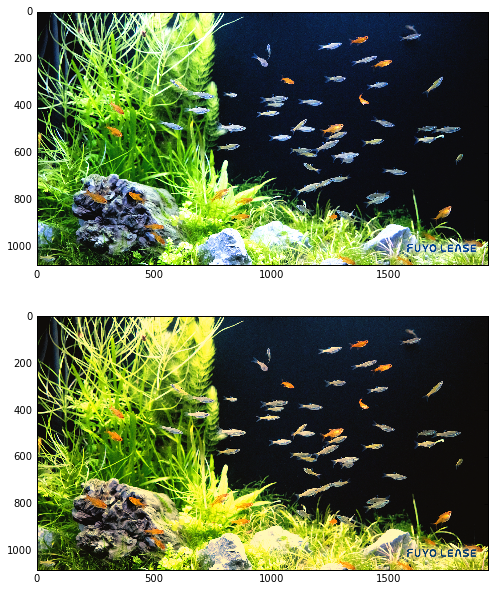

In [3]:
import os
import sys
import cv2
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

const_sRGB_xy = [[0.64, 0.33],
                 [0.30, 0.60],
                 [0.15, 0.06],
                 [0.3127, 0.3290]]
const_xyz_to_lms = [[0.8951000, 0.2664000, -0.1614000],
                    [-0.7502000, 1.7135000, 0.0367000],
                    [0.0389000, -0.0685000, 1.0296000]]
const_d65_xy = [0.31271, 0.32902]
const_d50_xy = [0.34567, 0.35850]

def get_white_point_conv_matrix(src=const_d65_xy, dst=const_d50_xy):
    """
    参考： http://w3.kcua.ac.jp/~fujiwara/infosci/colorspace/bradford.html
    """
    if len(src) == 2:
        src = [src[0], src[1], 1 - (src[0] + src[1])]
    if len(dst) == 2:
        dst = [dst[0], dst[1], 1 - (dst[0] + dst[1])]

    src = np.array(src)
    dst = np.array(dst)

    src = src / src[1]
    dst = dst / dst[1]

    # LMS値を求めよう
    # --------------------------------------
    ma = np.array(const_xyz_to_lms)
    ma_inv = linalg.inv(ma)

    src_LMS = ma.dot(src)
    dst_LMS = ma.dot(dst)

    # M行列を求めよう
    # --------------------------------------
    mtx = [[dst_LMS[0]/src_LMS[0], 0.0, 0.0],
           [0.0, dst_LMS[1]/src_LMS[1], 0.0],
           [0.0, 0.0, dst_LMS[2]/src_LMS[2]]]

    m_mtx = ma_inv.dot(mtx).dot(ma)

    return m_mtx


def color_cvt(img, mtx):
    """
    # 概要
    img に対して mtx を適用する。
    # 注意事項
    例によって、RGBの並びを考えている。BGRの並びの場合は
    img[:, :, ::-1] してから関数をコールすること。
    """
    img_max = np.iinfo(img.dtype).max
    img_min = np.iinfo(img.dtype).min

    r, g, b = np.dsplit(img, 3)
    ro = r * mtx[0][0] + g * mtx[0][1] + b * mtx[0][2]
    go = r * mtx[1][0] + g * mtx[1][1] + b * mtx[1][2]
    bo = r * mtx[2][0] + g * mtx[2][1] + b * mtx[2][2]

    out_img = np.dstack((ro, go, bo))

    out_img[out_img < img_min] = img_min
    out_img[out_img > img_max] = img_max

    return out_img


def xy_to_xyz(xy):
    rz = 1 - (xy[0][0] + xy[0][1])
    gz = 1 - (xy[1][0] + xy[1][1])
    bz = 1 - (xy[2][0] + xy[2][1])
    wz = 1 - (xy[3][0] + xy[3][1])

    xyz = [[xy[0][0], xy[0][1], rz],
           [xy[1][0], xy[1][1], gz],
           [xy[2][0], xy[2][1], bz],
           [xy[3][0], xy[3][1], wz]]

    return xyz


def get_rgb_to_xyz_matrix(gamut=const_sRGB_xy):

    # まずは xyz 座標を準備
    # ------------------------------------------------
    if np.array(gamut).shape == (4, 2):
        gamut = xy_to_xyz(gamut)
    elif np.array(gamut).shape == (4, 3):
        pass
    else:
        print("============ Fatal Error ============")
        print("invalid xy gamut parameter.")
        print("=====================================")
        sys.exit(1)

    gamut_mtx = np.array(gamut)

    # 白色点の XYZ を算出。Y=1 となるように調整
    # ------------------------------------------------
    large_xyz = [gamut_mtx[3][0]/gamut_mtx[3][1],
                 gamut_mtx[3][1]/gamut_mtx[3][1],
                 gamut_mtx[3][2]/gamut_mtx[3][1]]
    large_xyz = np.array(large_xyz)

    # Sr, Sg, Sb を算出
    # ------------------------------------------------
    s = linalg.inv(gamut_mtx[0:3]).T.dot(large_xyz)

    # RGB2XYZ 行列を算出
    # ------------------------------------------------
    s_matrix = [[s[0], 0.0,  0.0],
                [0.0,  s[1], 0.0],
                [0.0,  0.0,  s[2]]]
    s_matrix = np.array(s_matrix)
    rgb2xyz_mtx = gamut_mtx[0:3].T.dot(s_matrix)

    return rgb2xyz_mtx


def change_img_white_point(filename='wp04_1920x1080.jpg'):
    """
    # 概要
    色温度変換を行う。

    # 注意事項
    現状だと D65 --> D50 しか変換できない。
    気が向いたら任意の色温度に変換できるように拡張しよう。
    """
    img = cv2.imread(filename, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
    m_mtx = get_white_point_conv_matrix()

    # XYZ 変換 Matrix と組み合わせて RGB 空間用の mtx を求める
    # ----------------------------------------------------
    rgb2xyz_mtx = get_rgb_to_xyz_matrix(gamut=const_sRGB_xy)
    xyz2rgb_mtx = linalg.inv(rgb2xyz_mtx)
    mtx = xyz2rgb_mtx.dot(m_mtx).dot(rgb2xyz_mtx)

    # 求めた mtx を使って画像を変換
    # ----------------------------------------------------
    img_out = color_cvt(img[:, :, ::-1], mtx)[:, :, ::-1]
    img_out = np.round(img_out).astype(img.dtype)

    # オリジナルと加工後の画像を比較表示
    # ------------------------------------
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(2, 1, 1)  # 引数はそれぞれ 縦数、横数、index
    ax2 = fig.add_subplot(2, 1, 2)
    ax1.imshow(img[:, :, ::-1])
    ax2.imshow(img_out[:, :, ::-1])

    root, ext = os.path.splitext(filename)
    out_filename = root + "_modify" + ext
    cv2.imwrite(out_filename, img_out)

    
change_img_white_point()